# Idle States Residency Analysis

This notebook shows the features provided by the idle state analysis module. It will be necessary to collect the following events:

 - `cpu_idle`, to filter out intervals of time in which the CPU is idle
 - `sched_switch`, to recognise tasks on kernelshark

In [1]:
import logging
reload(logging)
log_fmt = '%(asctime)-9s %(levelname)-8s: %(message)s'
logging.basicConfig(format=log_fmt)

# Change to info once the notebook runs ok
logging.getLogger().setLevel(logging.INFO)

In [2]:
%matplotlib inline

import os

# Support to access the remote target
from env import TestEnv

# Support to configure and run RTApp based workloads
from wlgen import RTA, Ramp

# Support for trace events analysis
from trace import Trace

# Target Configuration

Our target is a Juno R2 development board running Linux.

In [3]:
# Setup a target configuration
my_conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'juno',
    
    # Target board IP/MAC address
    "host"        : '192.168.1.101',
    
    # Login credentials
    "username"    : 'root',
    "password"    : '',
    
    "results_dir" : "CPUIdleAnalysis",
    
    # RTApp calibration values (comment to let LISA do a calibration run)
    "rtapp-calib" :  {
        "0": 318, "1": 125, "2": 124, "3": 318, "4": 318, "5": 319
    },
    
    # Tools required by the experiments
    "tools"   : ['rt-app', 'trace-cmd'],
    "modules" : ['bl', 'cpufreq'],
    "exclude_modules" : ['hwmon'],
    
    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "cpu_idle",
            "sched_switch"
         ],
         "buffsize" : 10 * 1024,
    },
}

# Tests execution

In [4]:
# Initialize a test environment
te = TestEnv(my_conf, wipe=False, force_new=True)
target = te.target

2017-04-13 17:20:52,649 INFO    :         Target - Using base path: /data/lisa_fork/lisa
2017-04-13 17:20:52,650 INFO    :         Target - Loading custom (inline) target configuration
2017-04-13 17:20:52,652 INFO    :         Target - External tools using:
2017-04-13 17:20:52,652 INFO    :         Target -    ANDROID_HOME: /home/zhifei/zyang/android-sdk-linux
2017-04-13 17:20:52,653 INFO    :         Target -    CATAPULT_HOME: /data/lisa_fork/lisa/tools/catapult
2017-04-13 17:20:52,659 INFO    :         Target - Devlib modules to load: ['bl', 'cpufreq']
2017-04-13 17:20:52,660 INFO    :         Target - Connecting Android target [192.168.1.101:5555]
2017-04-13 17:20:52,662 INFO    :         Target - Connection settings:
2017-04-13 17:20:52,664 INFO    :         Target -    {'device': '192.168.1.101:5555'}
2017-04-13 17:20:53,309 INFO    :         Target - Initializing target workdir:
2017-04-13 17:20:53,313 INFO    :         Target -    /data/local/tmp/devlib-target
2017-04-13 17:21:0

# Workload configuration and execution

In [5]:
def experiment(te):

    # Create RTApp RAMP task
    rtapp = RTA(te.target, 'ramp', calibration=te.calibration())
    rtapp.conf(kind='profile',
               params={
                    'ramp' : Ramp(
                        start_pct =  60,
                        end_pct   =  20,
                        delta_pct =   5,
                        time_s    =   0.5).get()
              })

    # FTrace the execution of this workload
    te.ftrace.start()
    rtapp.run(out_dir=te.res_dir)
    te.ftrace.stop()

    # Collect and keep track of the trace
    trace_file = os.path.join(te.res_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

In [6]:
experiment(te)

2017-04-13 17:21:14,563 INFO    :          WlGen - Setup new workload ramp
2017-04-13 17:21:14,567 DEBUG   :          WlGen - Setup step [postrun] callback to [__postrun] function
2017-04-13 17:21:14,568 DEBUG   :          WlGen - Configuring a profile-based workload...
2017-04-13 17:21:14,570 DEBUG   :          RTApp - ref on big cpu: 1
2017-04-13 17:21:14,573 INFO    :          RTApp - Workload duration defined by longest task
2017-04-13 17:21:14,574 INFO    :          RTApp - Default policy: SCHED_OTHER
2017-04-13 17:21:14,576 INFO    :          RTApp - ------------------------
2017-04-13 17:21:14,578 INFO    :          RTApp - task [ramp], sched: using default policy
2017-04-13 17:21:14,582 INFO    :          RTApp -  | calibration CPU: 1
2017-04-13 17:21:14,583 INFO    :          RTApp -  | loops count: 1
2017-04-13 17:21:14,585 INFO    :          RTApp - + phase_000001: duration 0.500000 [s] (5 loops)
2017-04-13 17:21:14,586 INFO    :          RTApp - |  period   100000 [us], dut

# Parse trace and analyse data

In [7]:
# Base folder where tests folder are located
res_dir = te.res_dir
logging.info('Content of the output folder %s', res_dir)
!tree {res_dir}

2017-04-13 17:21:24,350 INFO    : Content of the output folder /data/lisa_fork/lisa/results/CPUIdleAnalysis


/data/lisa_fork/lisa/results/CPUIdleAnalysis
├── cluster_idle_state_residency.png
├── cpu_idle_state_residency.png
├── output.log
├── platform.json
├── ramp_00.json
├── rt-app-ramp-0.log
├── rt-app-ramp_1-0.log
├── rt-app-ramp_1-1.log
├── rt-app-ramp_2-2.log
├── trace.dat
├── trace.raw.txt
└── trace.txt

0 directories, 12 files


In [8]:
trace = Trace(te.platform, res_dir, events=my_conf['ftrace']['events'])

2017-04-13 17:21:24,514 DEBUG   : Loading [sched] events from trace in [/data/lisa_fork/lisa/results/CPUIdleAnalysis]...
2017-04-13 17:21:24,520 DEBUG   : Parsing events: ['cpu_idle', 'sched_switch']
2017-04-13 17:21:24,525 INFO    : Parsing FTrace format...
2017-04-13 17:21:24,930 DEBUG   : Events found on trace:
2017-04-13 17:21:24,931 DEBUG   :  - sched_switch
2017-04-13 17:21:24,932 DEBUG   :  - cpu_idle
2017-04-13 17:21:24,934 DEBUG   : Lookup dataset for tasks...
2017-04-13 17:21:24,937 INFO    : Collected events spans a 5.368 [s] time interval
2017-04-13 17:21:24,938 INFO    : Set plots time range to (0.000000, 5.367658)[s]
2017-04-13 17:21:24,940 DEBUG   : Registering [<trace.Trace object at 0x7f80de19e190>] local data frames
2017-04-13 17:21:24,941 DEBUG   :    functions_stats
2017-04-13 17:21:24,943 DEBUG   :    trace_event
2017-04-13 17:21:24,943 DEBUG   :       Analysis - Analysis: /data/lisa_fork/lisa/libs/utils/analysis
2017-04-13 17:21:24,945 DEBUG   :       Analysis - S

## Per-CPU Idle State Residency

It is possible to get the residency in each idle state of a CPU or a cluster with the following commands:

In [9]:
# Idle state residency for CPU 3
trace.data_frame.cpu_idle_state_residency(3)

,time
idle_state,
0,0.007986
1,0.088138
2,5.053175


The `IdleAnalysis` module provide methods for plotting residency data.

In [10]:
ia = trace.analysis.idle

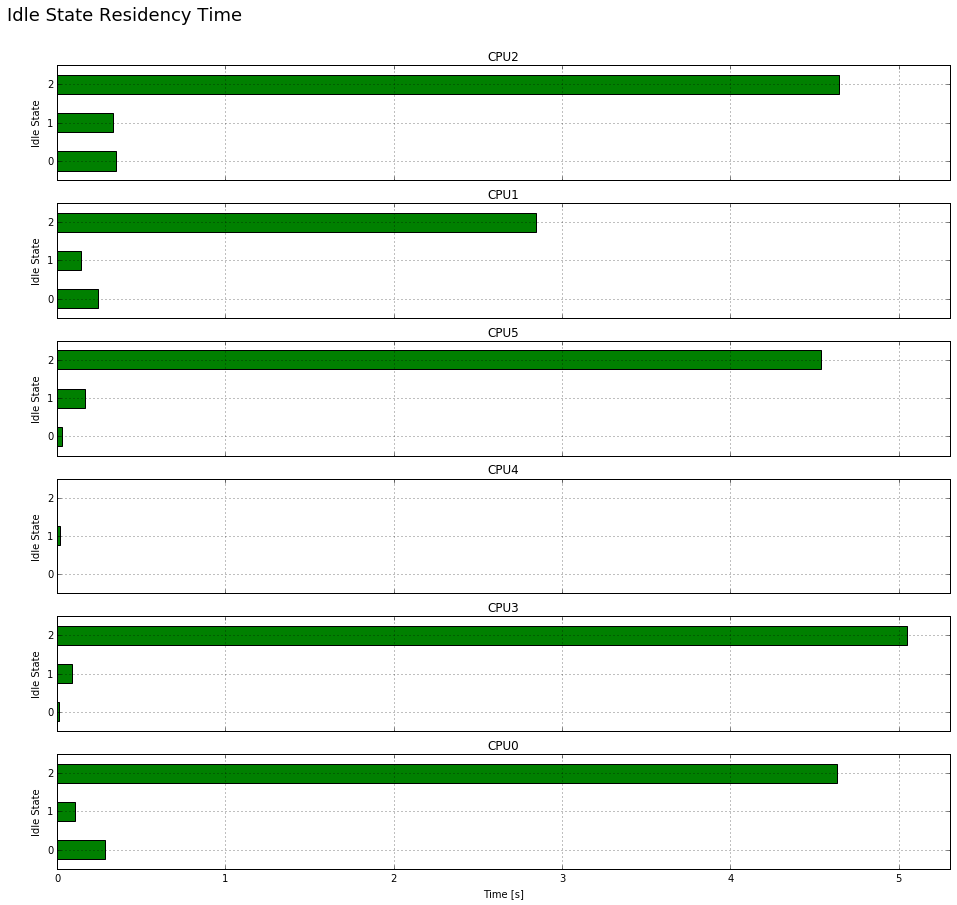

In [11]:
# Actual time spent in each idle state
ia.plotCPUIdleStateResidency([0, 1,2, 3, 4, 5])

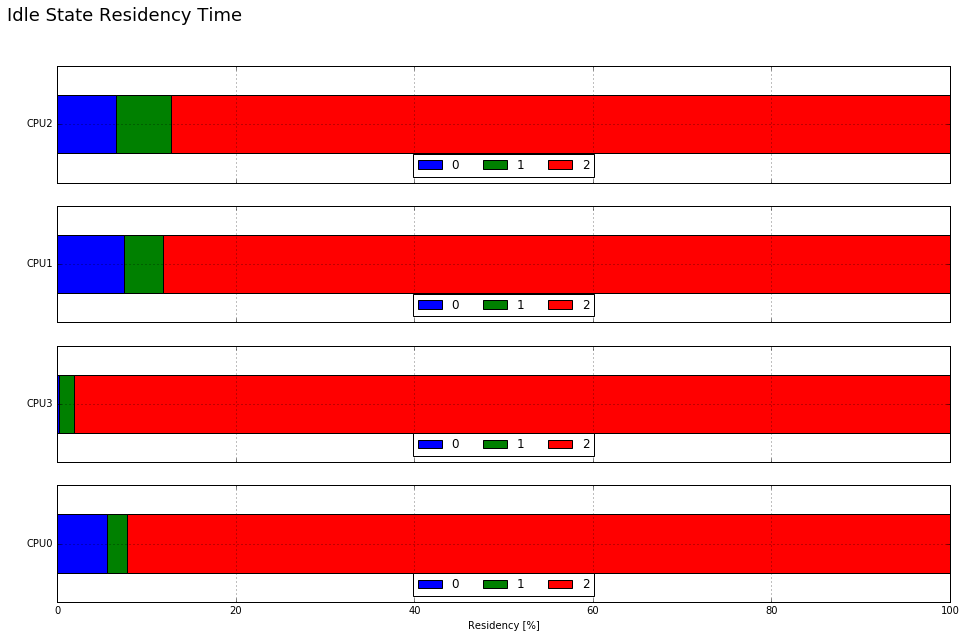

In [12]:
# Percentage of time spent in each idle state
ia.plotCPUIdleStateResidency([0,1,2,3], pct=True)

## Per-cluster Idle State Residency

In [13]:
# Idle state residency for the big cluster
trace.data_frame.cluster_idle_state_residency('big')

,time
idle_state,
0,0.304614
1,0.344383
2,2.940861


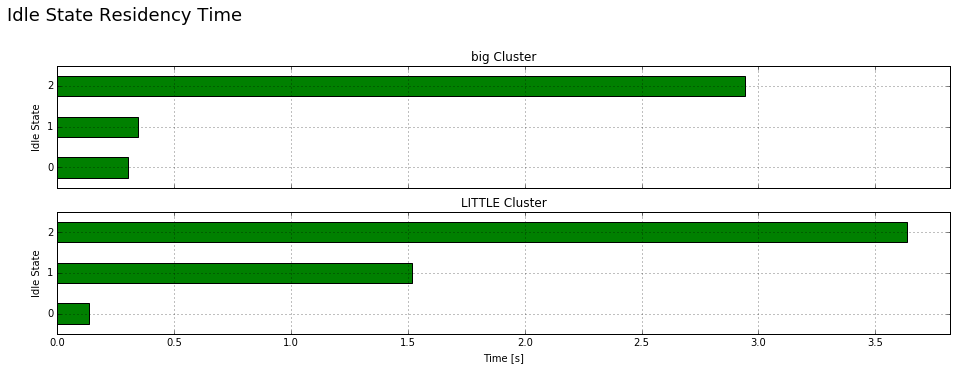

In [14]:
ia.plotClusterIdleStateResidency(['big', 'LITTLE'])

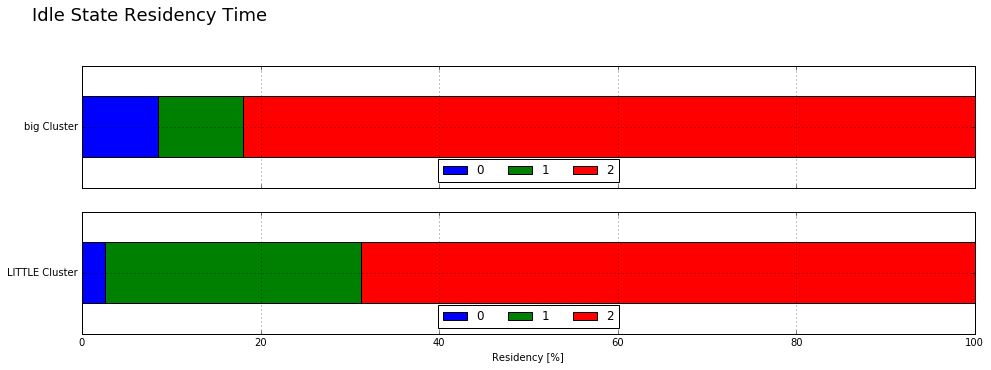

In [15]:
ia.plotClusterIdleStateResidency(['big', 'LITTLE'], pct=True)